In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn

from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# 采用Hog提取图片特征

In [2]:
def extract_hog_features(X):
    image_descriptors = []
    for i in range(len(X)):
        #print(i)
        '''
        参数解释：
        orientations：方向数
        pixels_per_cell：胞元大小
        cells_per_block：块大小
        block_norm：可选块归一化方法L2-Hys(L2范数)
        visualize：可视化
        '''
        fd, _ = hog(X[i], orientations=9, pixels_per_cell=(16, 16), cells_per_block=(16, 16),block_norm='L2-Hys', visualize=True)
        image_descriptors.append(fd) # 拼接得到所有图像的hog特征
    return image_descriptors        #返回的是训练部分所有图像的hog特征

# 提取单张图片特征

In [3]:
def extract_hog_features_single(X):
    image_descriptors_single = []
    fd, _ = hog(X, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(16, 16),block_norm='L2-Hys', visualize=True)
    image_descriptors_single.append(fd)
    return image_descriptors_single

# 读取数据

In [8]:
def read_data(label2id):       #label2id为定义的标签
    X = []
    Y = []
    path ='./jaffe'
    for label in os.listdir(path):                 #os.listdir用于返回指定的文件夹包含的文件或文件夹的名字的列表，此处遍历每个文件夹
        for img_file in os.listdir(os.path.join(path, label)):             #遍历每个表情文件夹下的图像
            image = cv2.imread(os.path.join(path, label, img_file))        #读取图像
            if image is not None:
                result = image/255.0                                           #图像归一化
                cv2.waitKey(0)
                cv2.destroyAllWindows()
                X.append(result)                                    #将读取到的所有图像的矩阵形式拼接在一起
                Y.append(label2id[label])                          #将读取到的所有图像的标签拼接在一起
    return X, Y                                               #返回的X,Y分别是图像的矩阵表达和图像的标签

# 划分数据 
## 训练集/测试集=7/3

In [9]:
label2id = {'anger':0, 'disgust':1, 'fear': 2,'happiness':3,'neutral':4,'sadness':5,'surprise':6}
X, Y = read_data(label2id)
X_features = extract_hog_features(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.3, random_state=42)

# 网格搜索选取SVM参数

# 对poly核进行网格搜索

In [8]:
from sklearn.model_selection import KFold, GridSearchCV
gamma_range = np.logspace(-10,1,10)
coef0_range = np.linspace(0,5,10)
C_range = np.linspace(0.01,30,10)
degree_range = np.linspace(0,10,11)
param_grid = dict(gamma = gamma_range
                 ,coef0 = coef0_range
                 ,C = C_range
                 ,degree = degree_range
                 )
cv = KFold(n_splits=5,shuffle=True,random_state=520)
grid = GridSearchCV(SVC(kernel = "poly"),param_grid=param_grid, cv=cv, n_jobs = -1) # n_jobs = -1 调用所有线程
grid.fit(X_train, Y_train)
print("The best parameters are %s with a score of %0.5f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 26.66777777777778, 'coef0': 3.8888888888888893, 'degree': 8.0, 'gamma': 7.742636826811277e-06} with a score of 0.75747


# 对sigmoid核进行网格搜索

In [12]:
from sklearn.model_selection import KFold, GridSearchCV
gamma_range = np.logspace(-10,1,10)
coef0_range = np.linspace(0,5,10)
C_range = np.linspace(0.01,30,20)
param_grid = dict(gamma = gamma_range
                 ,coef0 = coef0_range
                 ,C = C_range
                 )
cv = KFold(n_splits=5,shuffle=True,random_state=520)
grid = GridSearchCV(SVC(kernel = "sigmoid"),param_grid=param_grid, cv=cv, n_jobs = -1) # n_jobs = -1 调用所有线程
grid.fit(X_train, Y_train)
print("The best parameters are %s with a score of %0.5f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 30.0, 'coef0': 0.0, 'gamma': 0.5994842503189421} with a score of 0.70391


# 对rbf核进行网格搜索

In [15]:
from sklearn.model_selection import KFold, GridSearchCV
gamma_range = np.logspace(-10,1,10)
C_range = np.linspace(0.01,30,20)
param_grid = dict(gamma = gamma_range
                 ,C = C_range
                 )
cv = KFold(n_splits=5,shuffle=True,random_state=520)
grid = GridSearchCV(SVC(kernel = "rbf"),param_grid=param_grid, cv=cv, n_jobs = -1) # n_jobs = -1 调用所有线程
grid.fit(X_train, Y_train)
print("The best parameters are %s with a score of %0.5f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 18.95105263157895, 'gamma': 0.5994842503189421} with a score of 0.72391


# 对Linear核进行C取值搜索

In [23]:
C_range = np.linspace(0.01, 30, 30)
best_acc = -1
best_c = -1
for c in C_range:
    clf = SVC(kernel="linear", C=c)
    clf.fit(X_train, Y_train)
    acc = clf.score(X_test, Y_test)
    if acc > best_acc:
        best_acc = acc
        best_c = c
print("The best c is %0.5f with a score of %0.5f" % (best_c, best_acc))

The best c is 15.52207 with a score of 0.93750


# 结果分析：
在上面分别对多项式核(poly)，双曲正切核(sigmoid)，高斯径向基(rbf)，线性核(linear)进行了网格搜索

poly的最佳准确率为75.7%，sigmoid的最佳准确率为70.4%，rbf的最佳准确率为72.4%，linear的最佳准确率为93.8%

因此选择线性核对该数据效果最佳，其中最佳的参数C选择为15.52。

# SVM准确率

In [56]:
svm = SVC(C = 15.52, kernel='linear')
svm.fit(X_train, Y_train)
Y_predict = svm.predict(X_test)
acc = accuracy_score(Y_test, Y_predict)
print('SVM准确率为: ', acc)

SVM准确率为:  0.9375


# KNN准确率

In [28]:
knn = KNeighborsClassifier(n_neighbors=1) # k取1，最近邻准确率较高
knn.fit(X_train,Y_train)
Y_predict = knn.predict(X_test)
acc = accuracy_score(Y_test, Y_predict)
print('KNN准确率为: ', acc)

KNN准确率为:  0.859375


# 决策树准确率

In [29]:
tree_D = DecisionTreeClassifier()
tree_D.fit(X_train, Y_train)
Y_predict = tree_D.predict(X_test)
acc = accuracy_score(Y_test, Y_predict)
print('决策树准确率为: ', acc)

决策树准确率为:  0.40625


# 逻辑回归准确率

In [30]:
logistic = LogisticRegression()
logistic.fit(X_train, Y_train)
Y_predict = logistic.predict(X_test)
acc = accuracy_score(Y_test, Y_predict)
print('逻辑回归准确率为: ', acc)

逻辑回归准确率为:  0.453125


# 朴素贝叶斯准确率

In [31]:
mlt = GaussianNB()
mlt.fit(X_train, Y_train)
Y_predict = mlt.predict(X_test)
acc = accuracy_score(Y_test, Y_predict)
print('朴素贝叶斯准确率为: ', acc)

朴素贝叶斯准确率为:  0.609375


# 随机森林准确率

In [33]:
Forest = RandomForestClassifier(n_estimators=180,random_state=0)
Forest.fit(X_train, Y_train)
Y_predict = Forest.predict(X_test)
acc = accuracy_score(Y_test, Y_predict)
print('随机森林准确率为: ', acc)

随机森林准确率为:  0.65625


# SVM+Bagging准确率

In [52]:
from sklearn.ensemble import BaggingClassifier
svc = SVC(C = 15.52, kernel='linear')
clf = BaggingClassifier(base_estimator=svc, n_estimators=20,max_samples=1.0, max_features=1.0, 
                        bootstrap=True,bootstrap_features=False, n_jobs=1, random_state=1)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_predict)
print('SVM+Bagging准确率为: ', acc)

SVM+Bagging准确率为:  0.875


# AdaBoost准确率

In [55]:
from sklearn.ensemble import AdaBoostClassifier
dbt = AdaBoostClassifier(n_estimators=200, learning_rate=0.8)
dbt.fit(X_train, Y_train)
Y_predict = dbt.predict(X_test)
acc = accuracy_score(Y_test, Y_predict)
print('adaboost准确率为: ', acc)

SVM+Bagging准确率为:  0.296875


注:随机森林、SVM+Bagging、AdaBoost属于集成分类器，理论上需经网格搜索调参，才能达到最佳性能，这里未经调参，故准确率偏低。

# 绘制SVM分类结果的模糊矩阵

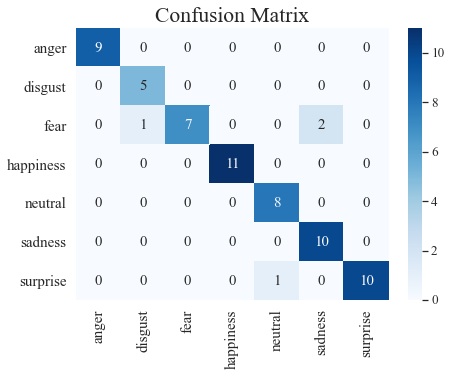

In [48]:
cm = confusion_matrix(Y_test, Y_predict)
xtick = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
ytick = xtick

f, ax = plt.subplots(figsize=(7, 5))
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

seaborn.set(font_scale=1.2)
plt.rc('font', family='Times New Roman',size=15)
seaborn.heatmap(cm,fmt='g', cmap='Blues', annot=True, cbar=True,xticklabels=xtick, yticklabels=ytick, ax=ax)
plt.title('Confusion Matrix', fontsize='x-large')
f.savefig('./模糊矩阵.png')
plt.show()

# 尝试导入单张图片查看分类效果
## 这里选用准确率最高的SVM做分类器

In [63]:
svm = SVC(C = 15.52, kernel='linear')
svm.fit(X_train, Y_train)

SVC(C=15.52, kernel='linear')

In [1]:
path = './test_pic.jpg'
image = cv2.imread(path)
result = image/255.0
X_Single = extract_hog_features_single(result)
#这里选择分类器的类别
predict = svm.predict(X_Single)
if predict == 0:
    print('angry')
elif predict == 1:
    print('disgust')
elif predict == 2:
    print('fear')
elif predict == 3:
    print('happy')
elif predict == 4:
    print('neutral')
elif predict == 5:
    print('sad')
elif predict == 6:
    print('surprise')

NameError: name 'cv2' is not defined